# Gravity Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit #used for curve fitting
import random
import uncertainties as un
from uncertainties import unumpy

In [2]:
#global variables:
global G
G = 6.6732e-11

In [14]:
#First step: load the data!
#Valley data:
valley_snum = np.linspace(0,7,8) #We've got 8 stations, which I number 0-7; snum = station number
valley_sID = ["Base","1","2","3","4","5","6","7"] #Here are the string names of the stations
#Gravity measurements at each station in the sID array:
#First measurement is Base 3 measurement, most recent base measurement to the other measurements.
valley_dial = np.array([3778.409,3778.52,3778.51,3778.449,3778.435,3778.56,3778.59,3778.46])

#Ridge data:
ridge_snum = np.linspace(0,4,5) #We've got 5 stations on the ridge, which I number 0-4, snum = station number
ridge_sID = ["1","2","3","4","5"] #Station string IDs, 1 = "31-Dec" in the excel sheet
ridge_dial = np.array([3774.1,3774,3774.1,3773.98,3773.92])

#Indices correspond to: Base 1, 2, 3, 4, 5. These will be used for the drift corrections.
base_redundancy = np.array([3778.44,3778.3,3778.409,3778.34,3778.265]) #These are all measurements from the base at different times

global staff_h
global laser_h
#Global staff length:
staff_h = 1.435 #meters
#Global laser height:
laser_h = 1.49 #meters

#We are given various distances from the staff and the laser, S(m). Let's record those here:
#The first value corresponds to the measurements at the BASE; each index beyond that correponds to the measurements at
#1, 2, 3, 4...6, 7.
valley_S_m = np.array([3.429,6.694,10.231,14.013,15.896,20.249,20.405,21.769])
#Here is the vertical angle between the top of the staff height and the top of the laser height at
#each measurement. In the initial array, 0 is up.
valley_ZA = np.array([84.20417,90.12222,90.08194,89.3875,89.97917,90.73472,98.47083,90.70972])

#For the stations on the ridge:
ridge_S_m = np.array([90.06,85.739,92.83,89.428,95.587])
ridge_ZA = np.array([75.50833,75.275,75.75694,75.3,75.98333])

In [15]:
#1. Determine the elevation of each gravity station relative to a base level.
#It is easiest if you choose the base level to be the same as the station with the lowest elevation.
#That way delta(z) for all of the stations will be a positive number.
#Your initial elevations will be determined with respect to the elevation of the ground at the theodolite.

#We need to derive the elevation from the data!
elevation = lambda SM,ZA: (SM*(np.cos(ZA*np.pi/180)))-staff_h+laser_h

#Let's test our elevation function on the base valley measurement.
print("Elevation difference of staff from laser in 'Base' measurement: (m)",elevation(valley_S_m[0],valley_ZA[0]))

#Alright, we have our elevation function. Now we feed our values
#into it to get the elevations of each measurement!
valley_elevations = []
for i in range(0,len(valley_S_m)):
    measurement_elevation = elevation(valley_S_m[i],valley_ZA[i])
    valley_elevations.append(measurement_elevation)

print("Elevation relative to the Base at each measurement location: (m)",np.round(valley_elevations,4))

#If we wanted to normalize this to be relative to the station with the lowest elevation, we would get:
adjustment = abs(min(valley_elevations))
valley_elevation_adj = valley_elevations + adjustment
print("Normalized elevations: (m) ",np.round(valley_elevation_adj,3))

#Let's get the ridge elevations using the same method
ridge_elevations =[]
for i in range(0,len(ridge_S_m)):
    measurement_elevation = elevation(ridge_S_m[i],ridge_ZA[i])
    ridge_elevations.append(measurement_elevation)

ridge_elevation_adj = ridge_elevations + adjustment
print("Normalized ridge elevations: (m) ",np.round(ridge_elevation_adj,3))

#Looking back at some figures of the Shale hills, this ~20 meter elevation difference seems just right between the valley and the ridge!

Elevation difference of staff from laser in 'Base' measurement: (m) 0.40127375630252415
Elevation relative to the Base at each measurement location: (m) [ 0.4013  0.0407  0.0404  0.2048  0.0608 -0.2047 -2.9508 -0.2146]
Normalized elevations: (m)  [3.352 2.991 2.991 3.156 3.012 2.746 0.    2.736]
Normalized ridge elevations: (m)  [25.542 24.799 25.845 25.699 26.157]


In [16]:
#2. Make drift corrections to the dial readings, convert the dial readings to mGal,
# and then make a correction for latitude, if you determine that one is required.
# Use the pdf calibration file to determine how to convert the drift-corrected dial readings to mGal
# and the map of the field location to determine the N-S distance between the valley and ridge sites.

Base measurements, initial:  [3778.44  3778.3   3778.409 3778.34  3778.265]
Base times, initial:  [    0   600   960  5640 11760]
Base measurements, initial points averaged:  [3778.4245 3778.34   3778.265 ]
Base times, adjusted:  [    0  5640 11760]


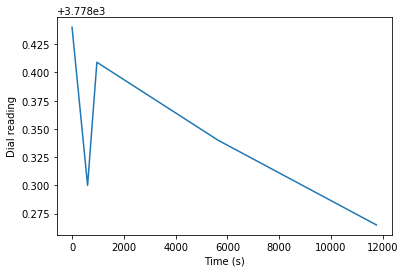

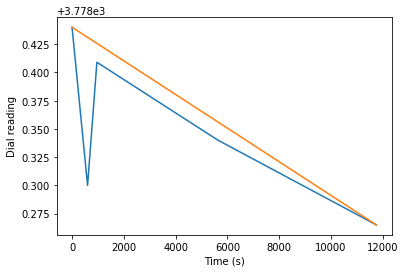

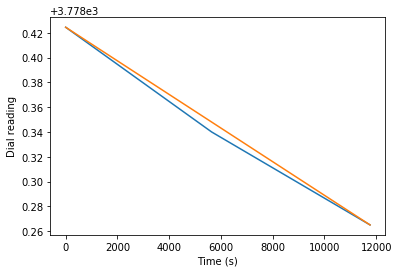

In [17]:
#Alright. Let's do the drift correction first by looking at the various redundant Base measurements and the times
#at which they were taken.
#1:52 is the first time, we'll normalize all the times to that one.
base_times = np.array([0,10,16,78+16,64+38+78+16])*60 #mult by 60 to convert mins to seconds
plt.figure()
plt.plot(base_times,base_redundancy)
plt.xlabel("Time (s)")
plt.ylabel("Dial reading")

print("Base measurements, initial: ",base_redundancy)
print("Base times, initial: ",base_times)

#I'm going to attribute the second point to be in error.
#Because this is over a short time period, we can approximate the drift to be linear.
#Let's build that linear drift interpolation:
slope = (base_redundancy[-1]-base_redundancy[0])/(base_times[-1]-base_times[0])
linear_func = lambda m,x,b: m*x+b

plt.figure()
plt.plot(base_times,base_redundancy)
plt.plot(base_times,linear_func(slope,base_times,base_redundancy[0]))
plt.xlabel("Time (s)")
plt.ylabel("Dial reading")

#This looks kinda rough. Let's try averaging the first three base points, since they were all taken in redundancy
#before the other measurements.
base_redundancy_adj = np.concatenate(([np.mean([base_redundancy[0],base_redundancy[2]])],base_redundancy[3:]))
base_times_adj = np.concatenate(([base_times[0]],base_times[3:]))
print("Base measurements, initial points averaged: ",base_redundancy_adj)
print("Base times, adjusted: ",base_times_adj)

#We'll need to adjust the line slope
slope2 = (base_redundancy_adj[-1]-base_redundancy_adj[0])/(base_times_adj[-1]-base_times_adj[0])
plt.figure()
plt.plot(base_times_adj,base_redundancy_adj)
plt.plot(base_times_adj,linear_func(slope2,base_times_adj,base_redundancy_adj[0]))
plt.xlabel("Time (s)")
plt.ylabel("Dial reading")

#I think this average best symbolizes the data. We'll use it to correct for the drift.
#This function gives the change in the "correct" dial reading over time. Now that we have this,
#we can map each of our measurements to a point on this line based on the time of the measurement.
#Each point will represent the amount of correction needed.
correction_func = lambda t: linear_func(slope2,t,base_redundancy_adj[0])

In [18]:
#Now, to actually apply the drift correction to the data will be a bit trickier.
#We'll need to follow the calibration table for each point.

#In order to get the drift corrected dial reading for each point, we'll need to get the times in seconds
#of each measurement.
valley_times = np.array([
16,
16+7,
16+7+8,
16+7+8+13,
16+7+8+13+13,
16+7+8+13+13+4,
16+7+8+13+13+4+5])*60

ridge_times = np.array([
16+7+8+13+13+4+5+39,
16+7+8+13+13+4+5+39+11,
16+7+8+13+13+4+5+39+11+26,
16+7+8+13+13+4+5+39+11+26+8,
16+7+8+13+13+4+5+39+11+26+8+12])*60

#Now that we have that, we can go ahead and plug these times into our drift linear function
#to get the corrected dial readings.

#This gives the dial readings in a global sense, but we need them to be relative to the initial measurement
#So in order to get the relative correction (the actual drift) we need to subtract out the initial point
#These values (at least in magnitude) will be the values added onto the dial readings reported in the excel sheet.
valley_drift_correction_dial = correction_func(valley_times)-base_redundancy_adj[0]
ridge_drift_correction_dial = correction_func(ridge_times)-base_redundancy_adj[0]

#Let's look at our dial corrections:
print("Valley drift corrections for each measurement (respective indicies) (dial): ",-valley_drift_correction_dial)
print("Ridge drift corrections for each measurement (respective indicies) (dial): ",-ridge_drift_correction_dial)

#Now we add these drift corrections onto our excel sheet measurements: DC = drift corrected
#The first valley point stays the same since it is a base measurement (taken at approx t=0)
valley_dial_DC = np.concatenate(([valley_dial[0]],valley_dial[1:]+(-valley_drift_correction_dial)))
ridge_dial_DC = ridge_dial+(-ridge_drift_correction_dial)

#Let's check out our drift corrected dial readings!
print("\n\nValley drift corrected values: ",np.round(valley_dial_DC,3))
print("Ridge drift corrected values: ",np.round(ridge_dial_DC,3))

Valley drift corrections for each measurement (respective indicies) (dial):  [0.01302041 0.01871684 0.02522704 0.03580612 0.0463852  0.04964031
 0.05370918]
Ridge drift corrections for each measurement (respective indicies) (dial):  [0.08544643 0.09439796 0.11555612 0.12206633 0.13183163]


Valley drift corrected values:  [3778.409 3778.533 3778.529 3778.474 3778.471 3778.606 3778.64  3778.514]
Ridge drift corrected values:  [3774.185 3774.094 3774.216 3774.102 3774.052]


In [19]:
#Now we can go ahead and convert to mGal.

#These all fall into the 3700 Counter Reading segment, which has a corresponding mGal measurement of 3791.57 mGal
mGal_0 = 3791.57 #mGal

#The interval factor is
interval = 1.02428

#Let's get the dial differences from the 3700 Counter Reading value,
#multiply this difference by the interval factor,
#then add in the base mGal value!
valley_mgal = ((valley_dial_DC-3700)*interval)+mGal_0
ridge_mgal = ((ridge_dial_DC-3700)*interval)+mGal_0

#Let's see our values:
print("Valley drift corrected values (mGal): ",np.round(valley_mgal,3))
print("Ridge drift corrected values (mGal): ",np.round(ridge_mgal,3))

print("Current difference after drift correction (mGal): ",np.round(np.mean(valley_mgal)-np.mean(ridge_mgal),3))
#Wow! That's a big difference. Let's see what the next corrections do:

Valley drift corrected values (mGal):  [3871.883 3872.01  3872.005 3871.95  3871.946 3872.085 3872.119 3871.99 ]
Ridge drift corrected values (mGal):  [3867.557 3867.463 3867.588 3867.471 3867.42 ]
Current difference after drift correction (mGal):  4.499


In [20]:
#Next is to make any latitude corrections.

#I am estimating a difference of 100 meters for the size of the test site.
#This is supported by the 95.587 meter S(m) value, though this might not be entirely N-S.
#Measuring the test site map with the image analysis software ImageJ gives approximitely 100 meters.
#Let's go with that.

gn = lambda lat: 978.03185*(1+0.005278895*np.sin(lat)**2 - 0.000023462*np.sin(lat)**4) #cm / s^2

#I found a value from Juniata College citing the Shale Hills to be about lat. 40.66552. I'll use this.
lat1 = 40.66552*(np.pi/180)
lat2 = (40.66552-(100*1/111000))*(np.pi/180)
gndiff = gn(lat1)-gn(lat2)
print(gndiff," in cm/s^2, Gal. In mGal: ",gndiff*1e3)

#The correction is 0.079 mGal, which is significant enough. We'll use it.
#The north-facing side of the test site, which is the valley, should thus have an extra 0.079 mGal due to lat.
#This should be subracted off.

#LC = lat corrected
valley_mgal_LC = valley_mgal -(gndiff*1e3)
print("\n\nLatitude corrected valley measurements: ",np.round(valley_mgal_LC,3))

7.99497183834319e-05  in cm/s^2, Gal. In mGal:  0.0799497183834319


Latitude corrected valley measurements:  [3871.803 3871.93  3871.925 3871.87  3871.866 3872.005 3872.039 3871.91 ]


In [21]:
(2*1500 + 8*2300 + 10*2700)/(2+8+10)

2420.0

In [22]:
(0.2*1200 + 18.8*2600)/(0.2+18.8)

2585.2631578947367

In [23]:
#Next:
# Calculate the Bouguer anomaly for each gravity measurement.
# Justify your selection of the density used for your calculations
# and determine what your uncertainties are (+/- error).

#Bouguer correction
BC = lambda rho,z: 1e5*2*np.pi*G*rho*z #in mGal
#Free air correction
FAC = lambda z: 0.3086*z #in mGal

#Factors in the density:
#Soil depths at the valley mouth test site and the ridge top seem pretty similar (less than or about 0.5 meters)
#More fractures in valley test site than ridge test site
#Ridge test site has reported density chart down to 25 meters; very volatile at the start where there are relatively more fractures
#It seems like there's an approximate average density of 2600 kg/m^3 on the ridgetop. This is entirely visual, with the smallest
#denomination of 500 kg/m^3. Based on John Taylor's error estimation and propogation textbook, I would use half that smallest denomination
#as my uncertainty. I'll settle on 2600 +- 250 kg/m^3 as my density on the ridgetop. This goes down for a measured 25 meters.

#The valley doesn't seem to have a density profile like the ridge. I'll have to estimate.
#There are more fractures at shallow depths, which would lower the average density
#but less fractures once you get deeper, which would raise the average density
#The soil in the valley is deeper, which would lower the average density
#Overall, I think we'd see a lower average density, but only slightly.
#so I'll estimate a lower value of 2400 +- 500 kg/m^3. I increased the uncertainty to account for the pure guestimation.

#For the z in each equation, I'm using the elevation found earlier for each site added on top of the average elevation I googled for State College
#This modification will normalize my values to sea level.

#Let's use Python's uncertainties package to prop errors through functions.
valley_rho = un.ufloat(2400,500)
ridge_rho = un.ufloat(2600,250)

valley_z = valley_elevation_adj
ridge_z = ridge_elevation_adj

valley_BC = BC(valley_rho,valley_z)
valley_FAC = FAC(valley_z)

ridge_BC = BC(ridge_rho,ridge_z)
ridge_FAC = FAC(ridge_z)

print("Valley Bouguer corrections: (mGal)",valley_BC)
print("Valley Free Air corrections: (mGal)",valley_FAC)

print("Ridge Bouguer corrections: (mGal)",ridge_BC)
print("Ridge Free Air corrections: (mGal)",ridge_FAC)

#Bouguer corrections are subtracted, FAC are added to the measurements

valley_mgal_BA = valley_mgal_LC-valley_BC+valley_FAC
ridge_mgal_BA = ridge_mgal-ridge_BC+ridge_FAC

Valley Bouguer corrections: (mGal) [0.33731507276902145+/-0.07027397349354614
 0.30103281056522957+/-0.06271516886775616
 0.3009973544215789+/-0.06270778217116227
 0.31754382881329857+/-0.06615496433610386
 0.30305126310208536+/-0.06313567981293444
 0.2763411218019663+/-0.0575710670420763 0.0+/-0
 0.2753355220322351+/-0.05736156709004898]
Valley Free Air corrections: (mGal) [1.03444265 0.923176   0.92306726 0.97381026 0.92936598 0.8474541
 0.         0.84437023]
Ridge Bouguer corrections: (mGal) [2.7845033661847363+/-0.26774070828699387
 2.7034603168858444+/-0.2599481073928696
 2.8175312178799636+/-0.27091646325768876
 2.8015663216382074+/-0.26938137708059684
 2.8515505213952688+/-0.27418755013416046]
Ridge Free Air corrections: (mGal) [7.88236083 7.65294449 7.97585594 7.93066257 8.07215764]


In [24]:
#Our incomplete Bouguer anomaly values:
print("Incomplete Bouguer anomaly valley values: (mGal)",valley_mgal_BA)
print("\n\nIncomplete Bouguer anomaly ridge values: (mGal)",ridge_mgal_BA)
print("\n\n\nDifference in incomplete bouguer anomalies (mGal): ",np.mean(valley_mgal_BA)-np.mean(ridge_mgal_BA))

Incomplete Bouguer anomaly valley values: (mGal) [3872.4999483793995+/-0.07027397349354614
 3872.5519956113026+/-0.06271516886775616
 3872.5475142721034+/-0.06270778217116227
 3872.525897989814+/-0.06615496433610386
 3872.4924422897143+/-0.06313567981293444
 3872.576111499863+/-0.0575710670420763 3872.039061054372+/-0
 3872.4791070370575+/-0.05736156709004898]


Incomplete Bouguer anomaly ridge values: (mGal) [3872.65452652951+/-0.26774070828699387
 3872.4128941175495+/-0.2599481073928696
 3872.7458345435916+/-0.27091646325768876
 3872.6003607481844+/-0.26938137708059684
 3872.6404172259895+/-0.27418755013416046]



Difference in incomplete bouguer anomalies (mGal):  -0.15+/-0.27


In [25]:
#Next up is the terrain correction. This correciton is not needed due to the anti-symmetric nature of the
#catchment's slopes and valley.

In [26]:
avg_valley = np.mean(valley_mgal_BA)
avg_ridge = np.mean(ridge_mgal_BA)

print("Average anomaly for the valley: (mGal) ",avg_valley)
print("Average anomaly for the ridge: (mGal) ",avg_ridge)

print("Difference in average anomalies: (mGal)",avg_valley-avg_ridge)

Average anomaly for the valley: (mGal)  3872.46+/-0.05
Average anomaly for the ridge: (mGal)  3872.61+/-0.27
Difference in average anomalies: (mGal) -0.15+/-0.27
